[0]	train-rmse:1327609.14575	eval-rmse:368610.21059
[1]	train-rmse:1259245.64537	eval-rmse:364300.22213
[2]	train-rmse:1195133.62142	eval-rmse:386099.49048
[3]	train-rmse:1142491.34866	eval-rmse:375010.30694
[4]	train-rmse:1092058.11508	eval-rmse:370435.73953
[5]	train-rmse:1044873.69893	eval-rmse:361469.88450
[6]	train-rmse:1001547.32080	eval-rmse:362689.73943
[7]	train-rmse:958448.44152	eval-rmse:384285.00445
[8]	train-rmse:919363.50779	eval-rmse:377530.70792
[9]	train-rmse:883556.10090	eval-rmse:370212.33522
[10]	train-rmse:850309.71180	eval-rmse:364432.84637
[11]	train-rmse:821518.20410	eval-rmse:365494.14845
[12]	train-rmse:791886.25197	eval-rmse:367080.74903
[13]	train-rmse:764288.33104	eval-rmse:359183.30495
[14]	train-rmse:739836.12506	eval-rmse:356647.82425
[15]	train-rmse:714715.38565	eval-rmse:365771.41920
[16]	train-rmse:688923.21139	eval-rmse:369225.30755
[17]	train-rmse:668555.65148	eval-rmse:366937.56860
[18]	train-rmse:646334.27847	eval-rmse:372653.32902
[19]	train-rmse

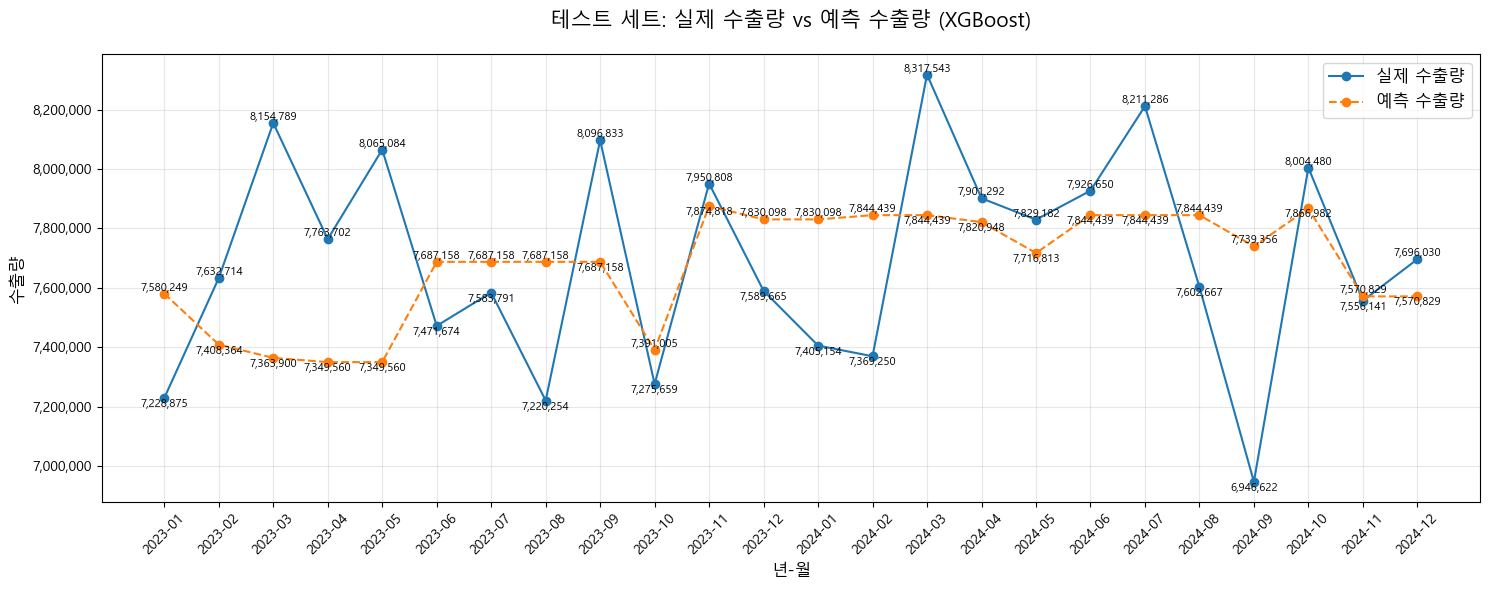


실제값과 예측값 비교 (XGBoost):
             실제 수출량   예측 수출량
date                        
2023-01-01  7228875  7580249
2023-02-01  7632714  7408364
2023-03-01  8154789  7363900
2023-04-01  7763702  7349560
2023-05-01  8065084  7349560
2023-06-01  7471674  7687158
2023-07-01  7583791  7687158
2023-08-01  7220254  7687158
2023-09-01  8096833  7687158
2023-10-01  7275659  7391005
2023-11-01  7950808  7874818
2023-12-01  7589665  7830098
2024-01-01  7405154  7830098
2024-02-01  7369250  7844439
2024-03-01  8317543  7844439
2024-04-01  7901292  7820948
2024-05-01  7829182  7716813
2024-06-01  7926650  7844439
2024-07-01  8211286  7844439
2024-08-01  7602667  7844439
2024-09-01  6946622  7739356
2024-10-01  8004480  7866982
2024-11-01  7556141  7570829
2024-12-01  7696030  7570829


In [10]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('data_integ.csv', parse_dates=['date'])  # 데이터 통합본 넣기 // 감성지수 데이터도 포함
df.set_index('date', inplace=True)

# Lag 및 파생변수 생성
# 이전 수출량 데이터를 반영해 시계열의 연속성과 패턴을 학습하도록 lag 및 파생 변수 생성
df['lag_1'] = df['export_restored'].shift(1) # 한 달 전 수출량
df['lag_2'] = df['export_restored'].shift(2) # 두 달 전 수출량
df['rolling_3'] = df['export_restored'].rolling(window=3).mean().shift(1) # 이전 3개월간 수출량 평균 (직전 월까지)
df['diff_1'] = df['export_restored'].diff(1).shift(1) # 직전 월 대비 수출량 차이 (변동성 반영)

# 타겟 변수와 피쳐 분리
X = df.drop(columns=['export_restored', 'export'])
y = df['export_restored']

# 학습/테스트 데이터 분할 (80:20) (시계열 순서 유지)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# DMatrix 변환
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# 모델 파라미터 설정
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
num_rounds = 300
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# XGBoost 모델 학습
model = xgb.train(params, dtrain, num_boost_round=num_rounds,
                  early_stopping_rounds=30, evals=watchlist)

# 예측 수행
preds = model.predict(dtest)

# 모델 성능 평가
def get_reg_eval(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

get_reg_eval(y_test, preds)

# ---------------------- 여기서부터는 시각화 코드 ----------------------------
# 예측 결과와 실제 값을 포함한 DataFrame 생성 
results_df = pd.DataFrame({
    '실제 수출량': y_test,
    '예측 수출량': preds
})

# 소수점 반올림 및 정수형 변환
results_df = results_df.round(0).astype(int)

# x축 눈금용 날짜 리스트 생성
dates = results_df.index.strftime('%Y-%m')

# 실제값과 예측값 시각화
plt.figure(figsize=(15, 6))

plt.plot(range(len(dates)), results_df['실제 수출량'], 
         marker='o', linestyle='-', label='실제 수출량', color='#1f77b4')
plt.plot(range(len(dates)), results_df['예측 수출량'], 
         marker='o', linestyle='--', label='예측 수출량', color='#ff7f0e')

# 실제값과 예측값 텍스트 표시 (겹치지 않게)
for i in range(len(dates)):
    real_val = results_df['실제 수출량'].iloc[i]
    pred_val = results_df['예측 수출량'].iloc[i]
    
    if real_val >= pred_val:
        plt.text(i, real_val, f'{real_val:,.0f}', 
                 verticalalignment='bottom', 
                 horizontalalignment='center',
                 fontsize=8)
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                 verticalalignment='top', 
                 horizontalalignment='center',
                 fontsize=8)
    else:
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                 verticalalignment='bottom', 
                 horizontalalignment='center',
                 fontsize=8)
        plt.text(i, real_val, f'{real_val:,.0f}', 
                 verticalalignment='top', 
                 horizontalalignment='center',
                 fontsize=8)

# 그래프 스타일링
plt.title('테스트 세트: 실제 수출량 vs 예측 수출량 (XGBoost)', fontsize=15, pad=20)
plt.xlabel('년-월', fontsize=12)
plt.ylabel('수출량', fontsize=12)
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)

# x축 설정
plt.xticks(range(len(dates)), dates, rotation=45)

# y축 포맷팅 (천 단위 쉼표)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

plt.tight_layout()
plt.show()

# 결과 출력 (선택 사항)
print("\n실제값과 예측값 비교 (XGBoost):")
print(results_df.to_string(float_format=lambda x: '{:,.0f}'.format(x)))


# 피처 중요도 시각화
# xgb.plot_importance(model, importance_type='weight', height=0.5)
# plt.title('XGBoost Feature Importance')
# plt.tight_layout()
# plt.show()